# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [431]:
data[data.isna().any(axis=1)]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
data = data.fillna('')

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

#### _Какое распределение классов в обучающей выборке?_

In [8]:
print(f"Доля 0-го класса равна {round(sum(train['target'] == 0) / train['target'].count() * 100, 2)}%")
print(f"Доля 1-го класса равна {round(sum(train['target'] == 1) / train['target'].count() * 100, 2)}%")

Доля 0-го класса равна 56.75%
Доля 1-го класса равна 43.25%


In [10]:
train[train['keyword'].isin(train['keyword'].value_counts()[:10].keys().to_list()) == 1].groupby(['keyword', 'target']).count()['id']

keyword     target
            0         12
            1         32
damage      0         19
            1         17
deluge      0         26
            1          5
derail      0         15
            1         15
fatalities  0         17
            1         16
fear        0         27
            1          3
refugees    0         13
            1         17
siren       0         31
            1          4
tsunami     0         20
            1         10
wreckage    1         34
Name: id, dtype: int64

<AxesSubplot:xlabel='target,keyword'>

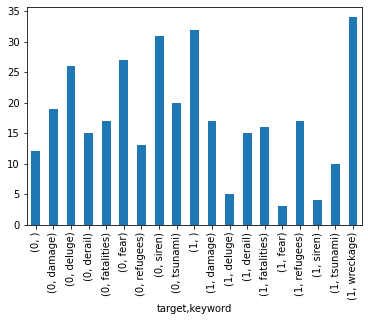

In [11]:
train[train['keyword'].isin(train['keyword'].value_counts()[:10].keys().to_list()) == 1].groupby(['target', 'keyword']).count()['id'].plot.bar()

#### Выводы: <br>
1. про пустую строку нечего сказать, потому что это "сборная солянка" из остальных ключевых слов;
2. слово _потоп_ (_deluge_) почти __не связывается с катастрофой__, возможно, из-за Великого потопа или многозначности (например, _шквал, поток_ про проблемы, жалобы или критику);
3. __то же__ можно сказать про _страх_ (_fear_) и _сирену_ (_сирена_): это может быть связано с тем, что эти слова достаточно "повседневные", поэтому легко придумать ситуацию с _сиреной_ или _страхом_, но без катастрофы;
4. _цунами_ (_tsunami_) тоже __в меньшей степени связывается с катастрофой__, возможно, из-за рассказов о солнечном цунами или защите от них;
5. слово _крушение_ (_wreckage_) __100% связано с катастрофой__ (нет ни одного твита с этим словом и без катастрофы): это слово достаточно редкое для "бытового" разговора и немногозначно (еще значит _крах_, что тоже вполне катастрофа).

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [12]:
train['string'] = train.keyword.str.cat([train.location, train.text], sep=' ')
train = train.drop(['id', 'keyword', 'location', 'text'], axis=1)

In [13]:
test['string'] = test.keyword.str.cat([test.location, test.text], sep=' ')
test = test.drop(['id', 'keyword', 'location', 'text'], axis=1)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
X = count_vec.fit_transform(train['string'].array)

#### _Какого размера получилась матрица?_

In [148]:
print('Размер матрицы:', X.shape)

Размер матрицы: (5329, 18455)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [16]:
count_vec.vocabulary_

{'bridge': 2948,
 '20collapse': 320,
 'ashes': 1928,
 '2015': 295,
 'australia': 2059,
 'ûªs': 18425,
 'collapse': 3914,
 'at': 1977,
 'trent': 16483,
 'among': 1628,
 'worst': 17813,
 'in': 8314,
 'history': 7773,
 'england': 5722,
 'bundled': 3085,
 'out': 11995,
 'for': 6503,
 '60': 755,
 'http': 7970,
 'co': 3861,
 't5trhjuau0': 15733,
 'hail': 7420,
 'carol': 3363,
 'stream': 15419,
 'illinois': 8249,
 'great': 7206,
 'michigan': 10594,
 'technique': 15888,
 'camp': 3261,
 'b1g': 2147,
 'thanks': 16013,
 'to': 16272,
 'bmurph1019': 2753,
 'hail_youtsey': 7421,
 'termn8r13': 15949,
 'goblue': 7088,
 'wrestleon': 17848,
 'oaskgki6qj': 11648,
 'police': 12634,
 'houston': 7933,
 'cnn': 3854,
 'tennessee': 15932,
 'movie': 10940,
 'theater': 16025,
 'shooting': 14647,
 'suspect': 15632,
 'killed': 9246,
 'by': 3150,
 'di8elzswnr': 4890,
 'rioting': 13800,
 'still': 15357,
 'couple': 4204,
 'of': 11708,
 'hours': 7925,
 'left': 9644,
 'until': 16884,
 'have': 7546,
 'be': 2383,
 'up': 

In [17]:
import re
import string

In [18]:
def bruh(c_v):
    list_digits = []
    list_punct = []
    hashtags = []
    mentions = []
    for w in c_v.vocabulary_.keys():
        if re.findall('[0-9]+', w):
            list_digits.append(w)
        if re.findall(f'[{string.punctuation}]+', w):
            list_punct.append(w)
        if w.startswith('#'):
            hashtags.append(w)
        elif w.startswith('@'):
            mentions.append(w)
    return list_digits, list_punct, hashtags, mentions

#### _Сколько таких слов нашлось?_

In [19]:
print(f'В словаре {len(bruh(count_vec)[0])} слов, содержащих цифры; {len(bruh(count_vec)[1])} слов, содержащих символы пунктуации; {len(bruh(count_vec)[2])} хэштегов и {len(bruh(count_vec)[3])} упоминаний')

В словаре 3812 слов, содержащих цифры; 315 слов, содержащих символы пунктуации; 0 хэштегов и 0 упоминаний


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [20]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [21]:
cnt_vec = CountVectorizer(tokenizer=tknzr.tokenize)
X_new = cnt_vec.fit_transform(train['string'].array)

In [149]:
cnt_vec.vocabulary_

{'bridge': 5275,
 '%': 1472,
 '20collapse': 1800,
 'ashes': 4530,
 '2015': 1773,
 ':': 2229,
 'australia': 4628,
 '\x89': 19587,
 'ûªs': 19640,
 'collapse': 6032,
 'at': 4567,
 'trent': 18450,
 'among': 4300,
 'worst': 19368,
 'in': 12552,
 'history': 8949,
 'england': 7415,
 'bundled': 5388,
 'out': 14999,
 'for': 8041,
 '60': 2077,
 '...': 1512,
 'http://t.co/t5trhjuau0': 11456,
 'hail': 8661,
 'carol': 5600,
 'stream': 17648,
 ',': 1483,
 'illinois': 12503,
 'great': 8518,
 'michigan': 14071,
 'technique': 18025,
 'camp': 5510,
 'b1g': 4691,
 'thanks': 18124,
 'to': 18284,
 '@bmurph1019': 2490,
 '@hail_youtsey': 2905,
 '.': 1509,
 '@termn8r13': 3718,
 '#goblue': 520,
 '#wrestleon': 1442,
 'http://t.co/oaskgki6qj': 10996,
 'police': 15494,
 'houston': 9082,
 'cnn': 5982,
 'tennessee': 18063,
 'movie': 14348,
 'theater': 18131,
 'shooting': 17007,
 'suspect': 17851,
 'killed': 13124,
 'by': 5442,
 'http://t.co/di8elzswnr': 9897,
 'rioting': 16377,
 'still': 17597,
 'a': 3943,
 'couple

In [22]:
print(f'В словаре {len(bruh(cnt_vec)[0])} слов, содержащих цифры; {len(bruh(cnt_vec)[1])} слов, содержащих символы пунктуации; {len(bruh(cnt_vec)[2])} хэштегов и {len(bruh(cnt_vec)[3])} упоминаний')

В словаре 3939 слов, содержащих цифры; 7337 слов, содержащих символы пунктуации; 1470 хэштегов и 1679 упоминаний


#### Сравнение результатов:
1. мы немного увеличили кол-во слов, сожержащих цифры, из-за того, что теперь есть хэштеги, упоминания и др. с цифрами;
2. кол-во слов, содержащих символы пунктуации, очень возросло из-за того, что теперь мы выделяем пунктуацию в отдельное слово (например, _?_, _!_, _..._) и разрешаем слову начинаться с пунктуации (в т.ч. хэштеги и упоминания);
3. теперь в словаре есть хэштеги и упоминания (притом достаточно много), потому что мы разрешили слову начинаться с пунктуации

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [23]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stops = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [25]:
def my_tokenizer(text):
    clean_tokens = []
    text = text.lower()
    tokens = tknzr.tokenize(text)
    for token in tokens:
        flag = 0
        if token.isalpha() and token not in stops:
            token = stemmer.stem(token)
            clean_tokens.append(token)
        elif token.startswith('#') and token[1:].isalpha():
            token = stemmer.stem(token)
            clean_tokens.append(token)
        elif (')' in token or '(' in token) and re.sub('[\)\(]', '', token) != '':
            for ch in re.sub('[\)\(]', '', token):
                if ch not in string.punctuation:
                    flag = 1
            if flag == 0:
                    token = stemmer.stem(token)
                    clean_tokens.append(token)
    return ' '.join(clean_tokens)

In [26]:
for t in train.head(10)['string']:
    print(f'{t} →→→ {my_tokenizer(t)}\n')

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0 →→→ bridg ash australia ûªs collaps trent bridg among worst histori england bundl australia

hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj →→→ hail carol stream illinoi great michigan techniqu camp thank #goblu #wrestleon

police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR →→→ polic houston cnn tennesse movi theater shoot suspect kill polic

rioting  Still rioting in a couple of hours left until I have to be up for class. →→→ riot still riot coupl hour left class

wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph →→→ wound lake highland crack path wipe morn beach run s

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [130]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [131]:
c_vec = CountVectorizer(tokenizer=my_tokenizer)
X_train = c_vec.fit_transform(train['string'].array)
X_test = c_vec.transform(test['string'].array)

In [132]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, train['target'].array)
pred = clf.predict(X_test)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.541


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [217]:
tfidf_vec = TfidfVectorizer(preprocessor=my_tokenizer)
X_train = tfidf_vec.fit_transform(train['string'].array)
X_test = tfidf_vec.transform(test['string'].array)

In [218]:
tfidf_vec.vocabulary_

{'bridg': 1081,
 'ash': 459,
 'australia': 543,
 'ûªs': 9999,
 'collaps': 1701,
 'trent': 9048,
 'among': 277,
 'worst': 9803,
 'histori': 3995,
 'england': 2746,
 'bundl': 1180,
 'hail': 3776,
 'carol': 1349,
 'stream': 8413,
 'illinoi': 4233,
 'great': 3652,
 'michigan': 5513,
 'techniqu': 8693,
 'camp': 1281,
 'thank': 8772,
 'goblu': 3570,
 'wrestleon': 9822,
 'polic': 6734,
 'houston': 4100,
 'cnn': 1660,
 'tennesse': 8725,
 'movi': 5738,
 'theater': 8780,
 'shoot': 7904,
 'suspect': 8548,
 'kill': 4741,
 'riot': 7391,
 'still': 8370,
 'coupl': 1901,
 'hour': 4096,
 'left': 4953,
 'class': 1610,
 'wound': 9808,
 'lake': 4857,
 'highland': 3964,
 'crack': 1921,
 'path': 6472,
 'wipe': 9723,
 'morn': 5702,
 'beach': 734,
 'run': 7533,
 'surfac': 8530,
 'elbow': 2658,
 'right': 7380,
 'knee': 4776,
 'airplan': 169,
 'somewher': 8160,
 'expert': 2908,
 'franc': 3283,
 'begin': 767,
 'examin': 2880,
 'debri': 2134,
 'found': 3262,
 'reunion': 7328,
 'island': 4452,
 'french': 3317,
 'a

In [219]:
clf = LogisticRegression()
clf.fit(X_train, train['target'].array)
pred = clf.predict(X_test)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.744


#### _Как изменилось качество?_
Качество возросло почти на __38%__, что является очень хорошим результатом!

In [220]:
tfidf_vec_new = TfidfVectorizer(preprocessor=my_tokenizer, max_df=0.9)
X_train_new = tfidf_vec_new.fit_transform(train['string'].array)
X_test_new = tfidf_vec_new.transform(test['string'].array)

In [221]:
tfidf_vec_new.vocabulary_

{'bridg': 1081,
 'ash': 459,
 'australia': 543,
 'ûªs': 9999,
 'collaps': 1701,
 'trent': 9048,
 'among': 277,
 'worst': 9803,
 'histori': 3995,
 'england': 2746,
 'bundl': 1180,
 'hail': 3776,
 'carol': 1349,
 'stream': 8413,
 'illinoi': 4233,
 'great': 3652,
 'michigan': 5513,
 'techniqu': 8693,
 'camp': 1281,
 'thank': 8772,
 'goblu': 3570,
 'wrestleon': 9822,
 'polic': 6734,
 'houston': 4100,
 'cnn': 1660,
 'tennesse': 8725,
 'movi': 5738,
 'theater': 8780,
 'shoot': 7904,
 'suspect': 8548,
 'kill': 4741,
 'riot': 7391,
 'still': 8370,
 'coupl': 1901,
 'hour': 4096,
 'left': 4953,
 'class': 1610,
 'wound': 9808,
 'lake': 4857,
 'highland': 3964,
 'crack': 1921,
 'path': 6472,
 'wipe': 9723,
 'morn': 5702,
 'beach': 734,
 'run': 7533,
 'surfac': 8530,
 'elbow': 2658,
 'right': 7380,
 'knee': 4776,
 'airplan': 169,
 'somewher': 8160,
 'expert': 2908,
 'franc': 3283,
 'begin': 767,
 'examin': 2880,
 'debri': 2134,
 'found': 3262,
 'reunion': 7328,
 'island': 4452,
 'french': 3317,
 'a

In [222]:
clf = LogisticRegression()
clf.fit(X_train_new, train['target'].array)
pred = clf.predict(X_test_new)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.744


In [223]:
print(f'Старый размер матрицы был {X_train.shape}. Новый размер - {X_train_new.shape}')

Старый размер матрицы был (5329, 10028). Новый размер - (5329, 10028)


#### _Как изменился размер матрицы, как изменилось качество?_
Размер и качество __не поменялись__, что, видимо, связано с тем, что у нас нет значений близких к единице...

In [234]:
tfidf_vec_new = TfidfVectorizer(preprocessor=my_tokenizer, min_df=0.0002)
X_train_new_new = tfidf_vec_new.fit_transform(train['string'].array)
X_test_new_new = tfidf_vec_new.transform(test['string'].array)

In [235]:
clf = LogisticRegression()
clf.fit(X_train_new_new, train['target'].array)
pred = clf.predict(X_test_new_new)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.749


#### _Удалось ли добиться улучшения качества?_
__Да, немного получилось__ (на 0.05). Это нам говорит о том, что значения __df__ близки к средне-низкому значению, хотя очень частотных слов нет.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [162]:
from sklearn.feature_extraction.text import HashingVectorizer

In [241]:
hash_vec = HashingVectorizer(preprocessor=my_tokenizer, n_features=5000)
X_train = hash_vec.fit_transform(train['string'].array)
X_test = hash_vec.transform(test['string'].array)

In [242]:
clf = LogisticRegression()
clf.fit(X_train, train['target'].array)
pred = clf.predict(X_test)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.723


#### _Какой из подходов показал самый высокий результат?_
Самый высокий результат показал __TF-IDF с ограничением снизу__

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [207]:
vec = CountVectorizer(ngram_range=(1, 1))
X_train = vec.fit_transform(train['string'].array)
X_test = vec.transform(test['string'].array)

In [208]:
clf = LogisticRegression()
clf.fit(X_train, train['target'].array)
pred = clf.predict(X_test)
print('F1: %.3f' % \
      f1_score(test['target'].array, pred))

F1: 0.753
